In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [211]:
def change_order(theta):
    order = np.argsort(theta[1,:])
    new_theta = np.zeros(theta.shape)
    for i in range(m):
        new_theta[0,i] = theta[0,order[i]]
        new_theta[1,i] = theta[1,order[i]]
    
    return new_theta

In [228]:
from mixture_poisson import poisson_random_param, sample_poisson, poisson_s_bar, poisson_theta_bar
from online_EM import online_EM,online_EM2
from batch_EM import batch_EM
# Parameters
n = 5000  # Size of the data set
m = 3 # Number of clusters
max_l = 50 # Maximum possible value for parameter lambda of Poisson

# Random parameters
l, p = poisson_random_param(m, max_l) # Ground truth

# Manual parameters
l = [1,20,50]
p = [0.4,0.35,0.25]
theta_true = np.array([p, l])

# Data set
Y, W = sample_poisson(n, l, p)

In [229]:
theta_true.shape

(2, 3)

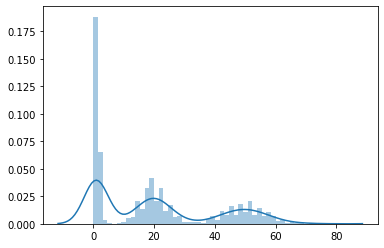

In [230]:
ax = sns.distplot(Y,kde=True,bins=50)

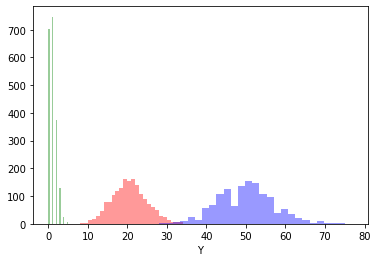

In [231]:
# visualize data set 
data = pd.DataFrame({'Y':Y,'W':W})
colors = ['g','r','b']

for i in range(m):
    ax = sns.distplot(data[data['W']==i]['Y'],kde=False,norm_hist=False,\
                      color = colors[i%len(colors)],label='Group{}'.format(i))

### Online EM [Test 1]
alpha = [1.,0.6]

In [232]:
# Initialization
p_init, l_init = poisson_random_param(m, max_l)
theta_init = np.array([p_init, l_init])
print(f"Initial Theta:\n{theta_init}")

# Stochastic Parameters
gamma_0 = 1
alphas = [1.,0.6]
gamma1 = np.array([gamma_0 * np.power(l, -alphas[0]) for l in range(1, n+1)])
gamma2 = np.array([gamma_0 * np.power(l, -alphas[1]) for l in range(1, n+1)])
#gamma3 = np.array([gamma_0 * np.power(l, -alphas[2]) for l in range(1, n+1)])

Initial Theta:
[[37.96779903 23.35302047  1.68162529]
 [ 0.32884968  0.28940906  0.38174126]]


In [233]:
s_g1, theta_g1, all_theta_g1 = online_EM(Y, theta_init, gamma1, \
                                         poisson_s_bar, poisson_theta_bar, save_iter_theta = True)
s_g2, theta_g2, all_theta_g2 = online_EM(Y, theta_init, gamma2, \
                                         poisson_s_bar, poisson_theta_bar, save_iter_theta = True)
#s_g3, theta_g3, all_theta_g3 = online_EM(Y, theta_init, gamma3, \
                                         #poisson_s_bar, poisson_theta_bar, save_iter_theta = True)
print("\n===============\nFinal results \n===============")
print(f"Truth:\n{theta_true}")
print(f"Online EM with alpha {alphas[0]} after {n} iterations:\n{theta_g1}")
print(f"Online EM with alpha {alphas[1]} after {n} iterations:\n{theta_g2}")
#print(f"Online EM with alpha {alphas[2]} after {n} iterations:\n{theta_g3}")


Final results 
Truth:
[[ 0.4   0.35  0.25]
 [ 1.   20.   50.  ]]
Online EM with alpha 1.0 after 5000 iterations:
[[ 0.44087561  0.24366987  0.31545452]
 [ 2.88308187 50.36051466 21.52633388]]
Online EM with alpha 0.6 after 5000 iterations:
[[ 0.36668111  0.33571807  0.29760083]
 [ 0.94711618 19.83307834 51.31826635]]


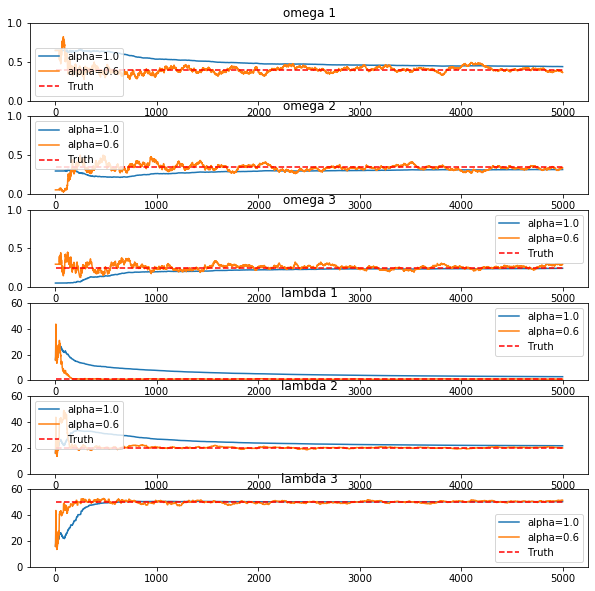

In [240]:
# visualize the process of parameter convergence 
names = ['omega 1','omega 2','omega 3','lambda 1','lambda 2','lambda 3']
truth = change_order(theta_true).reshape((1,-1))[0]

order1 = np.argsort(theta_g1[1,:])
order1 = np.concatenate([order1,order1+3])

order2 = np.argsort(theta_g2[1,:])
order2 = np.concatenate([order2,order2+3])

plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(6,1,i+1).set_title(names[i])
    plt.plot(all_theta_g1[1:,order1[i]],label='alpha=1.0')
    plt.plot(all_theta_g2[1:,order2[i]],label='alpha=0.6')
    plt.plot([1,n],[truth[i],truth[i]],'r--',label='Truth')
    if i<3:
        plt.ylim(0.,1.)
    else:
        plt.ylim(0,max_l+10)
    #plt.plot(all_theta_g3[1:,0],label='alpha=0.3')
    plt.legend()

### Online EM [Test 2]
Initialization sensitivity 

In [241]:
num_iter = 100
gamma = np.array([gamma_0 * np.power(l, -1.0) for l in range(1, n+1)])
all_theta =[]
for i in range(num_iter):
    p_init, l_init = poisson_random_param(m, max_l)
    theta_init = np.array([p_init, l_init])
    s, theta = online_EM(Y, theta_init, gamma, poisson_s_bar, poisson_theta_bar)
    #print(theta)
    theta = change_order(theta)
    all_theta.append(theta.reshape(1,-1)[0])


In [242]:
all_theta = np.stack(all_theta,axis=0)
print(all_theta)

[[2.58237906e-09 3.89281609e-01 6.10718388e-01 8.02078090e-01
  1.03504193e+00 3.26338253e+01]
 [3.89572554e-01 2.64748880e-01 3.45678566e-01 1.07714227e+00
  1.91550345e+01 4.29361333e+01]
 [3.86952150e-01 3.53701678e-01 2.59346172e-01 1.01870407e+00
  2.00938721e+01 4.94766278e+01]
 [3.85514530e-01 3.60243090e-01 2.54242380e-01 1.02014254e+00
  1.99779799e+01 5.01206409e+01]
 [3.85739742e-01 2.82433593e-01 3.31826666e-01 1.02066903e+00
  1.94338264e+01 4.35484048e+01]
 [3.86324924e-01 3.60306079e-01 2.53368997e-01 1.01966186e+00
  2.00726607e+01 5.01512721e+01]
 [3.87075297e-01 2.39822855e-01 3.73101848e-01 1.01799770e+00
  1.88475629e+01 4.13262008e+01]
 [3.89002678e-01 3.61018768e-01 2.49978554e-01 1.02288492e+00
  2.04246126e+01 5.02500169e+01]
 [4.54175790e-06 3.88864847e-01 6.11130612e-01 9.71218900e-01
  1.03603796e+00 3.26118778e+01]
 [7.03130386e-01 2.96664659e-01 2.04955685e-04 9.16808138e+00
  4.67738603e+01 5.11921075e+01]
 [3.89909821e-01 3.57596395e-01 2.52493784e-01 1.0

In [243]:
print(np.mean(all_theta,axis=0))
print(np.std(all_theta,axis=0))

[ 0.42273505  0.28335954  0.2939054   2.42277613 20.75553016 46.87174813]
[0.1159159  0.09073125 0.10732504 2.47839576 7.69709181 5.07038617]


[ 0.4   0.35  0.25  1.   20.   50.  ]


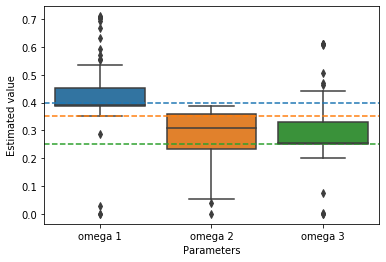

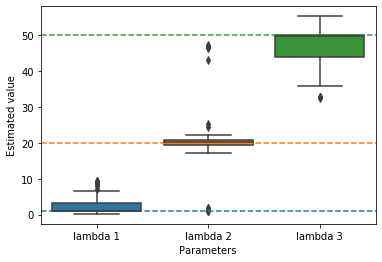

In [244]:
df = pd.DataFrame()
df['Estimated value'] = all_theta.reshape((-1,1))[:,0]
df['Parameters'] = names*num_iter

true_params = change_order(theta_true).reshape((1,-1))[0]
print(true_params)

df_omega =df[df['Parameters'].str.contains('omega')]
df_lambda =df[df['Parameters'].str.contains('lambda')]

plt.figure()
sns.boxplot(x='Parameters',y='Estimated value',data=df_omega)
for i in range(3):
    plt.plot([-0.5,2.5],[true_params[i],true_params[i]],'--')
    
plt.figure()
sns.boxplot(x='Parameters',y='Estimated value',data=df_lambda)
for i in range(3,6):
    plt.plot([-0.5,2.5],[true_params[i],true_params[i]],'--')